# Test: Correctness Evaluation of Annotat3d Image Processing Operations

This notebook implements bitwise comparisons between ANnotat3d custum operations and well stablished open frameworks for image processing. 

## Import libraries

Assures that the harpia module has already been compiled with cython, before (command: python3 setup.py)

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import csv
from typing import List, Tuple

#morphology functions
import harpia
from skimage import morphology
import harpia.morphology as harpia_morphology

#filters functions
from skimage.filters import prewitt,sobel,gaussian,unsharp_mask, laplace
from skimage.restoration import denoise_nl_means #non-local-mean
from skimage.feature import canny
from skimage.filters.rank import mean,median

from scipy import ndimage
import harpia.filters as filters

#threshold
from skimage.filters import threshold_local,threshold_mean,threshold_sauvola,threshold_niblack,threshold_otsu

import harpia.threshold as threshold


import skimage as ski
import harpia as hp


## Save path

In [ ]:
notebook_name = "test_correctness_report_scikit"
output_dir = f"{notebook_name}_plots"
os.makedirs(output_dir, exist_ok=True)
print(f"Plots will be saved to: {output_dir}")

## Framework

In [ ]:
def line_3D():
    kernel_2d = np.array([[1, 0, 0], [1, 0, 0], [1, 0, 0]], dtype=np.int32)
    # Stack the 2D kernel to form a 3D kernel (3 layers)
    kernel_3d = np.stack([kernel_2d, kernel_2d, kernel_2d])
    return kernel_3d

In [ ]:
def cube(size=1):
    """
    Create a cubic 3D footprint for erosion, where `size` is the erosion radius.

    Parameters:
    - size (int): Number of pixels to erode from each side. 
                  The resulting kernel will be of shape (2*size + 1)^3.

    Returns:
    - numpy.ndarray: A 3D structuring element for erosion.
    """
    kernel_shape = (2 * size + 1, 2 * size + 1, 2 * size + 1)
    return np.ones(kernel_shape, dtype=np.int32)

In [ ]:
def square():
    kernel = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=np.int32)
    kernel = kernel.reshape(1, kernel.shape[0], kernel.shape[1])
    return kernel

In [ ]:
def load_image(path, xsize, ysize, zsize, dtype, dtype_out):
    img = np.fromfile(path, dtype=dtype)
    img = img.reshape((zsize, ysize, xsize))
    img = img.astype(dtype = dtype_out)
    return img

In [ ]:
# Function to compare the results
def show_results_diff(result_custum, original_image=None, plot=False, operation = "", framework = "", 
                 slice_num = 0, figsize=(18, 6), save_path=None):  
    fontsize = 18
    # Perform bitwise comparison
    bitwise_diff = np.abs(original_image.astype(np.int32) - result_custum.astype(np.int32))
    
    if(plot):
        if(len(original_image.shape)==3):
            original_slice = original_image[slice_num,:,:]
            slice_groudtruth = result_groudtruth[slice_num,:,:]
            slice_custum = result_custum[slice_num,:,:]
            slice_diff = bitwise_diff[slice_num,:,:]
        # Visual comparison
        plt.figure(figsize=figsize)

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(original_slice, cmap='gray')
        plt.title("Original Image", fontsize = fontsize)
        plt.axis('off')

        # Custum result
        plt.subplot(1, 3, 2)
        plt.imshow(slice_custum, cmap='gray')
        plt.title(f"Annotat3d {operation}", fontsize = fontsize)
        plt.axis('off')

        # Bitwise difference
        plt.subplot(1, 3, 3)
        plt.imshow(slice_diff, cmap='hot')
        plt.title("Bitwise Difference", fontsize = fontsize)
        plt.axis('off')

        plt.tight_layout()
        
        # Save the plot if a save path is provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        
        plt.show()
    
    return 

In [ ]:
def show_results(result_custum, original_image=None, plot=False, operation = "", framework = "", 
                 slice_num = 0, figsize=(18, 6), save_path=None):  
    fontsize = 18
    # Perform bitwise comparison
    bitwise_diff = np.abs(original_image.astype(np.int32) - result_custum.astype(np.int32))
    
    if(plot):
        if(len(original_image.shape)==3):
            original_slice = original_image[slice_num,:,:]
            slice_groudtruth = result_groudtruth[slice_num,:,:]
            slice_custum = result_custum[slice_num,:,:]
            slice_diff = bitwise_diff[slice_num,:,:]
        # Visual comparison
        plt.figure(figsize=figsize)

        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(original_slice, cmap='gray')
        plt.title("Original Image", fontsize = fontsize)
        plt.axis('off')
        
        # Custum result
        plt.subplot(1, 2, 2)
        plt.imshow(slice_custum, cmap='gray')
        plt.title(f"Annotat3d {operation}", fontsize = fontsize)
        plt.axis('off')

        plt.tight_layout()
        
        # Save the plot if a save path is provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        
        plt.show()
    
    return 

In [ ]:
def compare_results(result_custum, result_groudtruth, original_image=None, plot=False, operation="", framework="", 
                    slice_num=0, figsize=(18, 6), save_path=None):
    fontsize = 18
    eps = 1e-8  # to prevent division by zero

    # Relative error in percentage
    relative_error = 100.0 * np.abs(result_groudtruth - result_custum) / (np.abs(result_groudtruth) + eps)

    if plot and original_image is not None and len(original_image.shape) == 3:
        original_slice = original_image[slice_num, :, :]
        slice_groudtruth = result_groudtruth[slice_num, :, :]
        slice_custum = result_custum[slice_num, :, :]

        plt.figure(figsize=figsize)

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(original_slice, cmap='gray')
        plt.title("Original Image", fontsize=fontsize)
        plt.axis('off')

        # Ground truth result
        plt.subplot(1, 3, 2)
        plt.imshow(slice_groudtruth, cmap='gray')
        plt.title(f"{framework} {operation}", fontsize=fontsize)
        plt.axis('off')

        # Custom result
        plt.subplot(1, 3, 3)
        plt.imshow(slice_custum, cmap='gray')
        plt.title(f"Annotat3d {operation}", fontsize=fontsize)
        plt.axis('off')

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        plt.show()

    # Filter out invalid values (e.g., inf or nan)
    rel_err_flat = relative_error[np.isfinite(relative_error)]

    # Compute percentage-based statistics
    mean_rel_error = rel_err_flat.mean()
    std_rel_error = rel_err_flat.std()
    accuracy = 100 - mean_rel_error

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Mean Relative Error: {mean_rel_error:.2f}%")
    print(f"Std Dev of Relative Error: {std_rel_error:.2f}%")

    # ----------- Save CSV Logging -----------
    if save_path:
        csv_path = os.path.join(os.path.dirname(save_path), "comparison_results.csv")

        file_exists = os.path.isfile(csv_path)

        with open(csv_path, mode='a', newline='') as csvfile:
            writer = csv.writer(csvfile)

            if not file_exists:
                writer.writerow([
                    "Operation", "Framework", "Image Shape", "Image Size (MiB)",
                    "Accuracy", "Mean Relative Error", "Std Dev of Relative Error"
                ])

            image_shape_str = str(original_image.shape)
            image_size_mib = original_image.nbytes / (1024 * 1024)

            writer.writerow([
                operation,
                framework,
                image_shape_str,
                f"{image_size_mib:.2f}",
                f"{accuracy:.2f}",
                f"{mean_rel_error:.2f}",
                f"{std_rel_error:.2f}",
            ])



In [ ]:
# Function to compare the results
def compare_results_bitwise(result_custum, result_groudtruth, original_image=None, plot=False, operation="", framework="", 
                    slice_num=0, figsize=(18, 6), save_path=None):  
    fontsize = 18
    # Perform bitwise comparison
    bitwise_diff = np.abs(result_groudtruth.astype(np.int32) - result_custum.astype(np.int32))
    
    if plot:
        if len(original_image.shape) == 3:
            original_slice = original_image[slice_num, :, :]
            slice_groudtruth = result_groudtruth[slice_num, :, :]
            slice_custum = result_custum[slice_num, :, :]
        
        # Visual comparison without bitwise difference
        plt.figure(figsize=figsize)

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(original_slice, cmap='gray')
        plt.title("Original Image", fontsize=fontsize)
        plt.axis('off')

        # Ground truth result
        plt.subplot(1, 3, 2)
        plt.imshow(slice_groudtruth, cmap='gray')
        plt.title(f"{framework} {operation}", fontsize=fontsize)
        plt.axis('off')

        # Custom result
        plt.subplot(1, 3, 3)
        plt.imshow(slice_custum, cmap='gray')
        plt.title(f"Annotat3d {operation}", fontsize=fontsize)
        plt.axis('off')

        plt.tight_layout()
        
        # Save the plot if a save path is provided
        if save_path:
            plt.savefig(save_path, bbox_inches='tight')
        
        plt.show()
    
    # Return pixel-wise statistics
    total_pixels = np.prod(original_image.shape)
    num_diff_pixels = np.count_nonzero(bitwise_diff)
    bitwise_diff_mean = bitwise_diff.mean()
    bitwise_diff_std = bitwise_diff.std()
    accuracy = ((total_pixels - num_diff_pixels) / total_pixels) * 100
    print(f"Total pixels: {total_pixels}")
    print(f"Different pixels: {num_diff_pixels}")
    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Difference value: {bitwise_diff_mean:.2f} ± {bitwise_diff_std:.2f}")

    # ----------- Save CSV Logging -----------
    if save_path:
        csv_path = os.path.join(os.path.dirname(save_path), "comparison_results_bitwise.csv")

        file_exists = os.path.isfile(csv_path)

        with open(csv_path, mode='a', newline='') as csvfile:
            writer = csv.writer(csvfile)

            if not file_exists:
                writer.writerow([
                    "Operation", "Framework", "Image Shape", "Image Size (MiB)",
                    "Accuracy", "Mean Bitwise Difference", "Std Dev of Bitwise Difference"
                ])

            image_shape_str = str(original_image.shape)
            image_size_mib = original_image.nbytes / (1024 * 1024)

            writer.writerow([
                operation,
                framework,
                image_shape_str,
                f"{image_size_mib:.2f}",
                f"{accuracy}",
                f"{bitwise_diff_mean:.2f}",
                f"{bitwise_diff_std:.2f}",
            ])
    return


In [ ]:
def show_images(
    images: List[np.ndarray], 
    labels: List[str],  
    figsize: Tuple[int, int] = (18, 6), 
    fontsize: int = 18, 
    slice_num: int = 0
) -> None:
    # Process images: if 3D, take the slice slice_num
    processed_images = []
    for img in images:
        if img.ndim == 3:
            processed_images.append(img[slice_num, :, :])
        else:
            processed_images.append(img)

    # Visual comparison
    plt.figure(figsize=figsize)

    total_plots = len(processed_images)
    for i, img in enumerate(processed_images):
        plt.subplot(1, total_plots, i + 1)
        plt.imshow(img, cmap='gray')
        plt.title(labels[i], fontsize=fontsize)
        plt.axis('off')

    plt.show()


In [ ]:
'''
def show_images(images, labels,  figsize=(18, 6), fontsize = 18,slice_num = 0):  
    for i in range(len(images)):
        if(len(images[i].shape)==3):
            images[i] = images[i][slice_num,:,:]

    # Visual comparison
    plt.figure(figsize=figsize)
    
    total_plots = len(images)
    for i in range(len(images)):
        plt.subplot(1, total_plots, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(labels[i], fontsize = fontsize)
        plt.axis('off')

    plt.show()
    
    return 
'''

## Grayscale input

In [ ]:
# small image - faster tests
xsize = 190
ysize = 207
zsize_original = 100
zsize = 100
image = load_image("../../example_images/grayscale/crua_A_190x207x100_16b.raw", xsize, ysize, zsize_original,'uint16', 'float32')
image = image[:zsize,:,:] #reduce size
visualized_slice_num = 0
image_slice = image[visualized_slice_num,:,:]
image_slice3D = np.expand_dims(image_slice, axis=-1).reshape((1, ysize, xsize))


In [ ]:
# bigger image - article data
'''
xsize = 2052
ysize = 2052
zsize_original = 2048
zsize = 2048
image = load_image("../../example_images/grayscale/Recon_2052x2052x2048_32bits.raw", xsize, ysize, zsize_original,'float32', 'float32')
image = image[:zsize,:,:] #reduce size
visualized_slice_num = 99
image_slice = image[visualized_slice_num,:,:]
image_slice3D = np.expand_dims(image_slice, axis=-1).reshape((1, ysize, xsize))
'''

In [ ]:
show_images([image], ['float32'], slice_num = 99)

## Filters 2D

### Non-local-mean

In [ ]:
from harpia.restoration import non_local_means
result_groudtruth = denoise_nl_means(image_slice, patch_size=21, patch_distance=5, h=500.0, fast_mode=False, sigma=0.0, preserve_range=True)
result_groudtruth3D = np.expand_dims(result_groudtruth, axis=-1).reshape((1, ysize, xsize))
out = non_local_means(hostImage=image_slice, small_window=5, big_window=21, h=500.0, sigma=0.0)
out = np.expand_dims(out, axis=-1).reshape((1, ysize, xsize))

compare_results(out, result_groudtruth3D, image_slice3D, plot=True, operation = "Non-local-means 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/nl_means_3D.png")

### Cany

In [ ]:
'''
result_groudtruth = cany(image_slice, sigma=1.0, low_threshold=None, high_threshold=None, mask=None, use_quantiles=False, mode='constant', cval=0.0)
result_groudtruth3D = np.expand_dims(result_groudtruth, axis=-1).reshape((1, ysize, xsize))
out = filters.canny(hostImage=image_slice, small_window=5, big_window=21, h=500.0, sigma=0.0)
out = np.expand_dims(out, axis=-1).reshape((1, ysize, xsize))

compare_results(out, result_groudtruth3D, image_slice3D, plot=True, operation = "Non-local-means 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/nl_means_3D.png")
'''

## Filters 3D

### Unsharp Mask

In [ ]:
result_groudtruth = unsharp_mask(image,1,1,preserve_range=True)
out = filters.unsharp_mask(image)

compare_results(out, result_groudtruth, image, plot=True, operation = "Unsharp Mask 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/unsharp_mask_3D.png")

### Median

In [ ]:
kernel = np.ones((3,3,3))
d = np.ones((3,3,3))
result_groudtruth = median(image.astype(np.uint16),d)
result_custum = filters.median(hostImage=image,nx=3,ny=3,nz=1)

compare_results(result_custum, result_groudtruth, image, plot=True, operation = "Median 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/median_3D.png")

### Mean

In [ ]:
kernel = np.ones((3,3,3))
d = np.ones((3,3,3))
result_groudtruth = mean(image.astype(np.uint16),d)
result_custum = filters.mean(hostImage=image, windowSize=3,type3d=1)

compare_results(result_custum, result_groudtruth, image, plot=True, operation = "Mean 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/mean_3D.png")

### Sobel

In [ ]:
sobel_h = ndimage.sobel(image, 0)  # horizontal gradient
sobel_v = ndimage.sobel(image, 1)  # vertical gradient
sobel_d = ndimage.sobel(image, 2)  # vertical gradient

result_groudtruth= np.sqrt(sobel_h**2 + sobel_v**2 + sobel_d**2)
#result_groudtruth3D = np.expand_dims(result_groudtruth, axis=-1).reshape((1, ysize, xsize))
out = filters.sobel(image,gpuMemory=0.2,verbose=1,type3d=1)

compare_results(out, result_groudtruth, image, plot=True, operation = "Sobel 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/sobel_3D.png")

### Prewitt

In [ ]:
prewitt_h = ndimage.prewitt(image, 0)  # horizontal gradient
prewitt_v = ndimage.prewitt(image, 1)  # vertical gradient
prewitt_d = ndimage.prewitt(image, 2)  # vertical gradient

result_groudtruth= np.sqrt(prewitt_h**2 + prewitt_v**2 + prewitt_d**2)
#result_groudtruth3D = np.expand_dims(result_groudtruth, axis=-1).reshape((1, ysize, xsize))
out = filters.prewitt(image,type3d=1)

compare_results(out, result_groudtruth, image, plot=True, operation = "Prewitt 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/prewitt_3D.png")

### Gaussian

In [ ]:
result_groudtruth = gaussian(image,1,mode='reflect',preserve_range=True)
out = filters.gaussian(image)

compare_results(out, result_groudtruth, image, plot=True, operation = "Gaussian 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/gaussian_3D.png")

### LoG

In [ ]:
kernel = np.ones((3,3,3))
d = np.ones((3,3,3))

result_groudtruth = gaussian(image,1,mode='reflect',preserve_range=True)
result_groudtruth = laplace(result_groudtruth)

result_custum = filters.gaussian(image)
result_custum = filters.laplace(hostImage=result_custum, type3d=1)

compare_results(result_custum, result_groudtruth, image, plot=True, operation = "LoG 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/log_3D.png")

In [ ]:
help(filters.non_local_means)

## Threshold 3D

### Sauvola

In [ ]:
result_groudtruth = image > threshold_sauvola(image, window_size=15, k=0.000020, r=None)
result_groudtruth = (result_groudtruth.astype(np.uint8)) * 255
out = threshold.threshold_sauvola(hostImage=image, hostOutput = None, windowSize = 15, weight=0.000020, type3d=1)

compare_results_bitwise(out, result_groudtruth, image, plot=True, operation = "Threshold Savoula 3D", framework="scikit", 
                slice_num=10, figsize = (15,30), save_path=f"{output_dir}/threshold_savoula_3D.png")

### NiBlack

In [ ]:
result_groudtruth = image > threshold_niblack(image, window_size=15, k=0.000020)
result_groudtruth = (result_groudtruth.astype(np.uint8)) * 255
out = threshold.threshold_niblack(hostImage=image, hostOutput = None, windowSize = 15, weight=0.000020, type3d=1)

compare_results_bitwise(out, result_groudtruth, image, plot=True, operation = "Threshold Niblack 3D", framework="scikit", 
                slice_num=10, figsize = (15,30), save_path=f"{output_dir}/threshold_niblack_3D.png")


### Local Gauss

In [ ]:
result_groudtruth = image > threshold_local(image, block_size=7, method='gaussian', mode='reflect')
result_groudtruth = (result_groudtruth.astype(np.uint8)) * 255
out = threshold.threshold_gaussian(hostImage=image,hostOutput = None,sigma = 1, type3d=1)

compare_results_bitwise(out, result_groudtruth, image, plot=True, operation = "Threshold Local Gaussian 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/threshold_gaussian_3D.png")


### Mean

In [ ]:
#nosso algoritmo pega a média da janela, o algoritmo do scikit parece usar a média global da imagem.
result_groudtruth = image > threshold_local(image, block_size=25, method='mean', mode='reflect')
result_groudtruth = (result_groudtruth.astype(np.uint8)) * 255
out = threshold.threshold_mean(hostImage=image,type3d=1, windowSize=25)

compare_results_bitwise(out, result_groudtruth, image, plot=True, operation = "Threshold Mean 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/threshold_mean_3D.png")

### Otsu

In [ ]:
#threshold_otsu(image=None, nbins=256, hist=hist)

In [ ]:
#threshold.otsu(histogramCounts=hist.astype(np.int32), nbins=256)

In [ ]:
def compute_otsu_histogram(image, nbins=256):
    """
    Compute histogram and number of bins exactly as used in skimage.filters.threshold_otsu.

    Parameters:
    -----------
    image : np.ndarray
        Input grayscale image.
    nbins : int, optional
        Number of histogram bins. Default is 256.

    Returns:
    --------
    hist : np.ndarray
        Histogram counts (length nbins).
    nbins : int
        Number of bins (same as input).
    bin_edges : np.ndarray
        Edges of histogram bins (length nbins+1).
    """
    image = np.ravel(image)
    imin, imax = image.min(), image.max()

    if imin == imax:
        # Edge case: image is constant
        hist = np.array([len(image)])
        bin_edges = np.array([imin, imax])
        return hist, 1, bin_edges

    hist, bin_edges = np.histogram(image, bins=nbins, range=(imin, imax))
    return hist, nbins, bin_edges

In [ ]:
'''
result_groudtruth = image > threshold_otsu(image=image)
result_groudtruth = (result_groudtruth.astype(np.uint8)) * 255

hist,_,_ = compute_otsu_histogram(image, nbins=256)
out = image > threshold.otsu(histogramCounts=hist.astype(np.int32), nbins=256)
out = (out.astype(np.uint8)) * 255

compare_results_bitwise(out, result_groudtruth, image, plot=True, operation = "Mean 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/threshold_mean_3D.png")
'''


## Morphology grayscale operations in 3D 

### footprint

In [ ]:
footprint = cube()

### Erosion

In [ ]:
#Custum operation
result_custum = harpia_morphology.erosion(image, footprint)
result_custum = result_custum.squeeze()

#Scikit-learn operation
selem = morphology.cube(3)
result_groudtruth = morphology.erosion(image, selem)

compare_results(result_custum, result_groudtruth, image, plot=True, operation = "Erosion 3D", framework="scikit", 
                slice_num=visualized_slice_num, figsize = (15,30), save_path=f"{output_dir}/grayscale_erosion.png")

### Dilation 

In [ ]:
#Custum operation
result_custum = harpia_morphology.dilation(image, footprint)
result_custum = result_custum.squeeze()

#Scikit-learn operation
selem = morphology.cube(3)
result_groudtruth = morphology.dilation(image, selem)

compare_results(result_custum, result_groudtruth, image, plot=True, operation = "Dilation 3D", framework="scikit", 
                slice_num=visualized_slice_num, figsize = (15,30), save_path=f"{output_dir}/grayscale_dilation.png")

### Opening 

In [ ]:
#Custum operation
result_custum = harpia_morphology.opening(image, footprint)
result_custum = result_custum.squeeze()

#Scikit-learn operation
selem = morphology.cube(3)
result_groudtruth = morphology.opening(image, selem)

compare_results(result_custum, result_groudtruth, image, plot=True, operation = "Opening 3D", framework="scikit", 
                slice_num=visualized_slice_num, figsize = (15,30), save_path=f"{output_dir}/grayscale_opening.png")

### Closing

In [ ]:
#Custum operation
result_custum = harpia_morphology.closing(image, footprint)
result_custum = result_custum.squeeze()

#Scikit-learn operation
selem = morphology.cube(3)
result_groudtruth = morphology.closing(image, selem)

compare_results(result_custum, result_groudtruth, image, plot=True, operation = "Closing 3D", framework="scikit", 
                slice_num=visualized_slice_num, figsize = (15,30), save_path=f"{output_dir}/grayscale_closing.png")

### Reconstruction

In [ ]:
#Custum operation
seed = image
for i in range(10):
    seed = harpia_morphology.erosion(seed, footprint)
result_custum = harpia_morphology.reconstruction(seed, image, "dilation")
result_custum = result_custum.squeeze()

#Scikit-learn operation
selem = morphology.cube(3)
result_groudtruth = morphology.reconstruction(seed,image, method='dilation')

compare_results(result_custum, result_groudtruth, seed, plot=True, operation = "Recosntruction", framework="scikit", 
                slice_num=visualized_slice_num, figsize = (15,30), save_path=f"{output_dir}/grayscale_reconstruction_dilation.png")

In [ ]:
#Custum operation
seed = image
for i in range(10):
    seed = harpia_morphology.dilation(seed, footprint)
result_custum = harpia_morphology.reconstruction(seed, image, "erosion")
result_custum = result_custum.squeeze()

#Scikit-learn operation
selem = morphology.cube(3)
result_groudtruth = morphology.reconstruction(seed,image, method='erosion')

compare_results(result_custum, result_groudtruth, seed, plot=True, operation = "Recosntruction", framework="scikit", 
                slice_num=visualized_slice_num, figsize = (15,30), save_path=f"{output_dir}/grayscale_reconstruction_erosion.png")

### Top hat (White tophat)

In [ ]:
#Custum operation
footprint_size = 20
result_custum = harpia_morphology.white_tophat(image, cube(footprint_size))
result_custum = result_custum.squeeze()

#Scikit-learn operation
selem = morphology.cube(2*footprint_size+1)
result_groudtruth = morphology.white_tophat(image, selem)

compare_results(result_custum, result_groudtruth, image, plot=True, operation = "TopHat 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/grayscale_tophat.png")

### Bottom hat (Black tophat)

In [ ]:
#Custum operation
footprint_size = 20
result_custum = harpia_morphology.black_tophat(image, cube(footprint_size))
result_custum = result_custum.squeeze()

#Scikit-learn operation
selem = morphology.cube(2*footprint_size+1)
result_groudtruth = morphology.black_tophat(image, selem)

compare_results(result_custum, result_groudtruth, image, plot=True, operation = "BottomHat 3D", framework="scikit", 
                slice_num=visualized_slice_num, figsize = (15,30), save_path=f"{output_dir}/grayscale_bottomhat.png")

### Top hat recosntruction (Avizo's inspired algorithm)

This algorithm was inspired by Avizo's implementation of the TopHat segemntation. We did not have acces to the Avizo's results to make a bitwise comparison.
(Ref: https://www.thermofisher.com/software-em-3d-vis/xtra-library/xtras/interactive-top-hat-by-reconstruction)

In [ ]:
#Custum operation
footprint_size = 13
result_custum = harpia_morphology.white_tophat_reconstruction(image, cube(footprint_size))
result_custum = result_custum.squeeze()

show_results(result_custum, image, plot=True, operation = "TopHat 3D", slice_num=visualized_slice_num, save_path=f"{output_dir}/grayscale_tophat_reconstruction.png")

### Bottom hat recosntruction (Avizo's inspired algorithm)

This algorithm was inspired by Avizo's implementation of the TopHat segemntation. We did not have acces to the Avizo's results to make a bitwise comparison.
(Ref: https://www.thermofisher.com/software-em-3d-vis/xtra-library/xtras/interactive-top-hat-by-reconstruction)

In [ ]:
#Custum operation
footprint_size = 13
result_custum = harpia_morphology.black_tophat_reconstruction(image, cube(footprint_size))
result_custum = result_custum.squeeze()

show_results(result_custum, image, plot=True, operation = "TopHat 3D", slice_num=visualized_slice_num, save_path=f"{output_dir}/grayscale_bottomhat_reconstruction.png")

In [ ]:
def process_image(data, plot=False):
    zsize, ysize, xsize = data.shape  # Get dimensions
    binarized_data = np.empty_like(data, dtype = 'int32')  # Prepare output array of same shape

    for slice_idx in range(zsize):
        slice_data = data[slice_idx, :, :]

        # Find min and max for the current slice
        min_val = slice_data.min()
        max_val = slice_data.max()

        # Compute threshold
        threshold = (max_val + min_val) // 2

        # Apply threshold to the slice to create a binary image
        binarized_slice = np.where(slice_data >= threshold, 1, 0)

        # Store the binarized slice in the output array
        binarized_data[slice_idx, :, :] = binarized_slice

    # Plot the first slice if plot flag is True
    if plot:
        plt.figure(figsize=(10, 4))

        # Plot original first slice
        plt.subplot(1, 2, 1)
        plt.imshow(data[0, :, :], cmap='gray')
        plt.title('Original First Slice')
        plt.axis('off')

        # Plot binarized first slice
        plt.subplot(1, 2, 2)
        plt.imshow(binarized_data[0, :, :], cmap='gray')
        plt.title('Binarized First Slice')
        plt.axis('off')

        plt.show()

    return binarized_data

## Binary input

In [ ]:

# original img
xsize = 190
ysize = 207
zsize_original = 100
zsize = 100
image_binary = load_image("../../example_images/binary/crua_A_190x207x100_16b.raw", xsize, ysize, zsize_original,'uint16', 'int32')
image_binary = image_binary[:zsize,:,:] #reduce size
image_binary_slice = image_binary[0,:,:]
image_binary_slice3D = np.expand_dims(image_binary_slice, axis=-1).reshape((1, ysize, xsize))



In [ ]:
'''
# original img
xsize = 1540
ysize = 1540
zsize_original = 1000
zsize = 1000
image_binary = load_image("/ibira/lnls/labs/tepui/home/egon.borges/workshop/Recon_fdk__tomo_z1_930_z1z2_1000_esp_1264_expt_1s_000_1540x1540x1000_float32.raw", xsize, ysize, zsize_original,'float32', 'float32')
image_binary = image_binary[:zsize,:,:] #reduce size
image_binary_slice = image_binary[0,:,:]
image_binary_slice3D = np.expand_dims(image_binary_slice, axis=-1).reshape((1, ysize, xsize))

'''

## Morphology binary operations in 3D 

### Erosion

In [ ]:
footprint = cube(1)

In [ ]:
#Custum operation
result_custum = harpia_morphology.binary_erosion(image_binary, footprint)
result_custum = result_custum.squeeze()

#Scikit-learn operation
selem = morphology.cube(3)
result_groudtruth = morphology.erosion(image_binary, selem)

compare_results(result_custum, result_groudtruth, image_binary, plot=True, operation = "Erosion 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/binary_erosion.png")

### Dilation 

In [ ]:
#Custum operation
result_custum = harpia_morphology.binary_dilation(image_binary, footprint)
result_custum = result_custum.squeeze()

#Scikit-learn operation
selem = morphology.cube(3)
result_groudtruth = morphology.dilation(image_binary, selem)

compare_results(result_custum, result_groudtruth, image_binary, plot=True, operation = "Dilation 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/binary_dilation.png")

### Opening 

In [ ]:
#Custum operation
result_custum = harpia_morphology.binary_opening(image_binary, footprint)
result_custum = result_custum.squeeze()

#Scikit-learn operation
selem = morphology.cube(3)
result_groudtruth = morphology.opening(image_binary, selem)

compare_results(result_custum, result_groudtruth, image_binary, plot=True, operation = "Opening 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/binary_opening.png")

### Closing

In [ ]:
#Custum operation
result_custum = harpia_morphology.binary_closing(image_binary, footprint)
result_custum = result_custum.squeeze()

#Scikit-learn operation
selem = morphology.cube(3)
result_groudtruth = morphology.closing(image_binary, selem)

compare_results(result_custum, result_groudtruth, image_binary, plot=True, operation = "Closing 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/binary_closing.png")

### Reconstruction

In [ ]:
#Custum operation
marker = harpia_morphology.erosion(image_binary, line_3D())

result_custum = harpia_morphology.binary_reconstruction(marker, image_binary, "dilation")
result_custum = result_custum.squeeze()

#Scikit-learn operation
selem = morphology.cube(3)
result_groudtruth = morphology.reconstruction(marker, image_binary, method='dilation')

compare_results(result_custum, result_groudtruth, marker, plot=True, operation = "recosntruction 3D", 
                framework="scikit", slice_num=0, figsize = (15,30), save_path=f"{output_dir}/binary_reconstruction_dilation.png")

### Smoothing

In [ ]:
#Custum operation
result_custum = harpia_morphology.binary_smoothing(image_binary, footprint)
result_custum = result_custum.squeeze()

#Scikit-learn operation
selem = morphology.cube(3)
result_groudtruth = morphology.opening(image_binary, selem)
result_groudtruth = morphology.closing(result_groudtruth, selem)

compare_results(result_custum, result_groudtruth, image_binary, plot=True, operation = "Smoothing 3D", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/binary_reconstruction_erosion.png")

### Fill Holes

In [ ]:
#Custum operation
result_custum = harpia_morphology.fill_holes(image_binary)
result_custum = result_custum.squeeze()

show_results_diff(result_custum, image_binary, plot=True, operation = "fill holes 3D", slice_num=3, figsize = (15,30), save_path=f"{output_dir}/binary_fill_holes3.png")

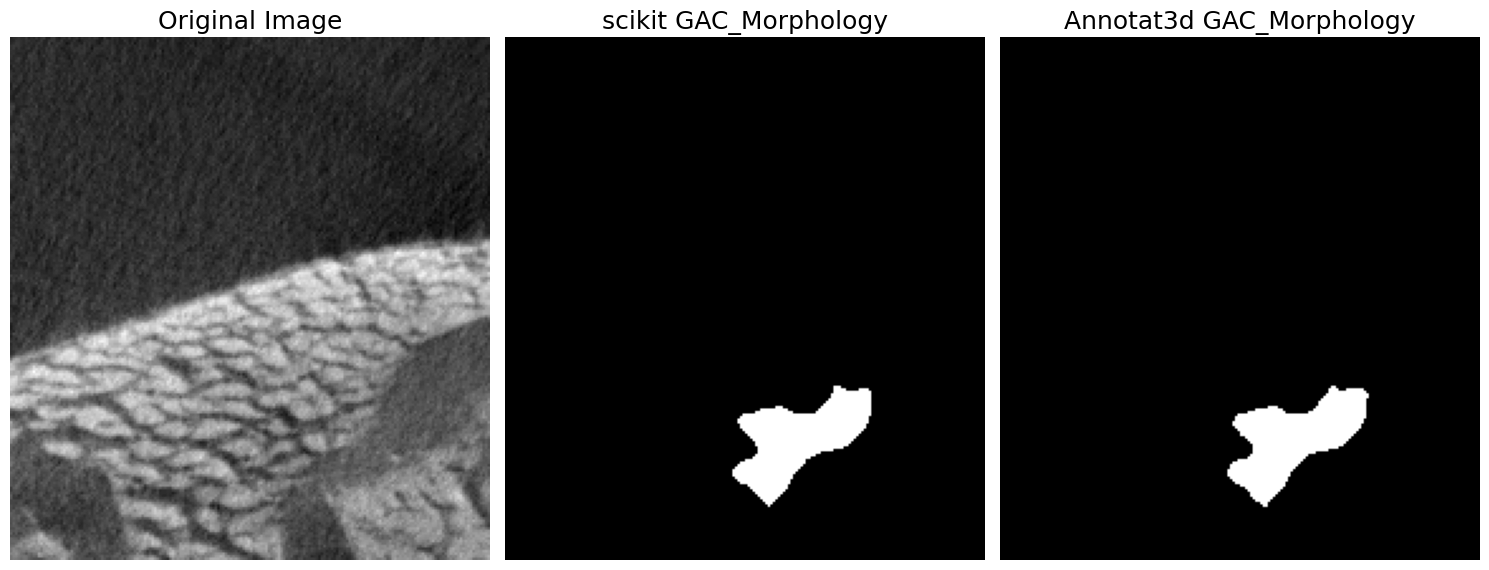

Total pixels: 39330
Different pixels: 32
Accuracy: 99.92%
Difference value: 0.00 ± 0.03


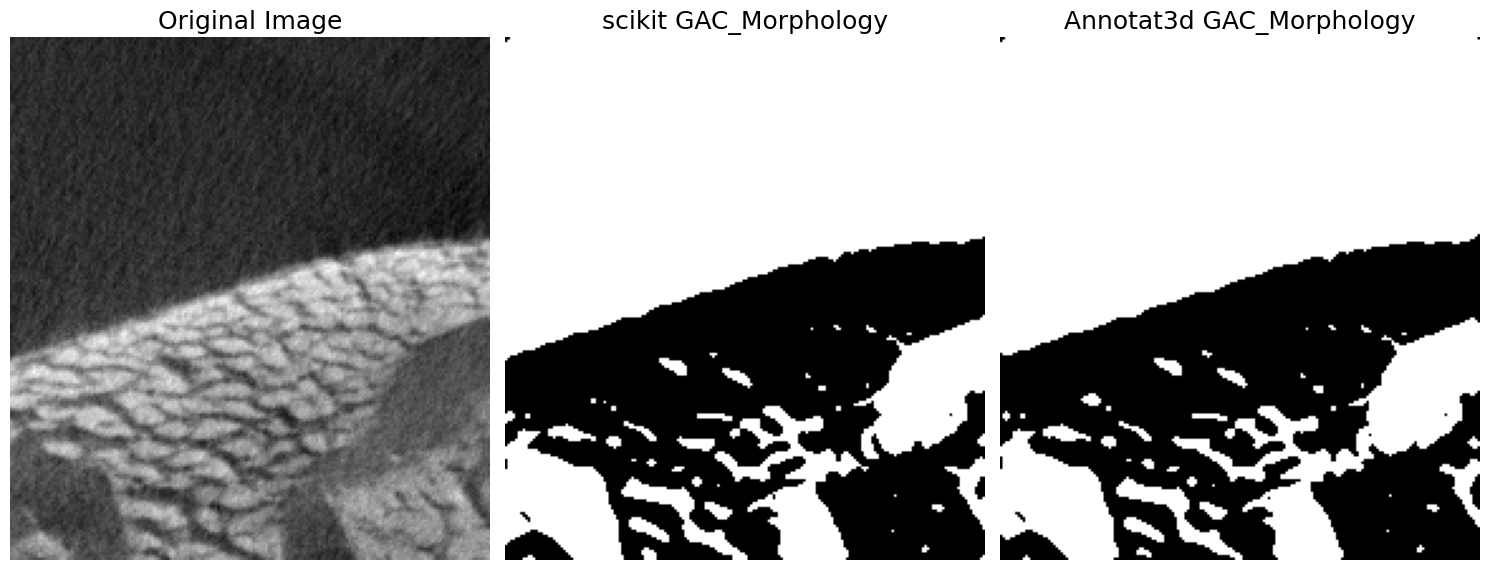

Total pixels: 39330
Different pixels: 244
Accuracy: 99.38%
Difference value: 0.01 ± 0.08


In [130]:
import numpy as np
import matplotlib.pyplot as plt
import skimage as ski
import harpia as hp

# === Morphological ACWE ===
init_ls = ski.segmentation.checkerboard_level_set(image_slice.shape, 6).astype(bool)


# Harpia version
ls_hp = hp.segmentation.morphological_chan_vese(
    image_slice,
    num_iter=35,
    init_level_set=init_ls,
    smoothing=1
)

# scikit-image version
ls_ski = ski.segmentation.morphological_chan_vese(
    image_slice, num_iter=35, init_level_set=init_ls, smoothing=1
)

# === Morphological GAC ===
gimage = ski.segmentation.inverse_gaussian_gradient(image_slice).astype(np.float32)

center_y, center_x = 155, 120
radius = 10
rr, cc = ski.draw.disk((center_y, center_x), radius, shape=image_slice.shape)
init_ls2 = np.zeros_like(image_slice, dtype=bool)
init_ls2[rr, cc] = True

# Harpia version
ls2_hp = hp.segmentation.morphological_geodesic_active_contour(
    gimage,
    num_iter=50,
    init_level_set=init_ls2,
    smoothing=1,
    balloon=1,
    threshold=0.017,
)

# scikit-image version
ls2_ski = ski.segmentation.morphological_geodesic_active_contour(
    gimage,
    num_iter=50,
    init_level_set=init_ls2,
    smoothing=1,
    balloon=1,
    threshold=0.017,
)

compare_results_bitwise(ls2_ski.reshape(1,*ls2_ski.shape), ls2_hp.reshape(1,*ls2_hp.shape), image_slice3D, plot=True, operation = "GAC_Morphology", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/GAC_morphology.png")

compare_results_bitwise(ls_ski.reshape(1,*ls_ski.shape), ls_hp.reshape(1,*ls_hp.shape), image_slice3D, plot=True, operation = "GAC_Morphology", framework="scikit", 
                slice_num=0, figsize = (15,30), save_path=f"{output_dir}/snakes_morphology.png")